# Discussion: proposals for constrained RVs

## Takeaways from this notebook
1. One of the most time-consuming parts of writing a Metropolis sampler for a higher-dimensional problem is tuning the proposal distribution to get a good acceptance ratio.
2. For the original Metropolis algorithm, the proposal distribution needs to be symmetric, which presents challenges in case of constrained domains.
3. This notebook provides some tips for building proposal distributions.

## Motivation
When implementing the random walk Metropolis algorithm for the real problem in notebook 3f.1, we found that once the Metropolis algorithm and the model were hand-coded, we spent most of our time tuning the proposal distribution. There is a host of problems to solve including how many dimensions to jump in at a time and how large the jumps should be.  Another problem is how to deal with constrained variables - the proposal can result in a value that does not satisfy the constraint.  For example the jump could result in a negative proposal for a standard deviation or variance, which makes no sense.  Another example are random variables that represent distributions over probabilities or something like time of day, day of year, etc.  This notebook discusses options in these cases.

### Rely on accept-reject mechanism
The first choice is to rely on the Metropolis accept/reject stage to enforce the constraint.  This works because the prior of the entire model is 0 if any variable is out of range.  Thus in the accept/reject stage we always reject such steps.

Here's an example of this situation for a probability $p \sim \text{Beta}(1,2)$.

```python
import numpy

def prior(p):
    prior = 1.
    # prior modified by other variables
    return prior * ((1-p) if 0 <= p and p <= 1. else 0)
    
def log_prior(p):
    logp = 0.
    # add logs of other priors to logp
    return logp + (numpy.log(1-p) if 0 <= 0 and p <= 0 else -numpy.inf)
```

We see that regardless of values for other variables, if $p \notin [0,1]$, we return a zero prior (or negative infinity for log priors) and therefore random walk Metropolis will never make the jump.

The problem with this approach is that if we have many constrained variables in the model, we are likely to violate at least one constraint often and could thus incur an untolerable number of rejections.

The second choice is to ensure the the proposal distribution never violates the constraint on the random variable and thus the rejections are mitigated.  However this is not always trivial as we must ensure that the Metropolis symmetry condition holds even in the new construction.

In the following we will discuss some options and provide examples for:
- a random variable $p$ constrained to $[0,1]$, for example representing a probability
- a random variable that must be positive, such as a variance or standard deviation $\sigma \geq 0$.

Before diving in, let us summarize the problem.  Given a constrained random variable (RV), we want to build a proposal function $q(x^*|x)$, which never proposes jumps outside the constraint and satisfies the Metropolis symmetry requirement $q(x^*|x) = q(x|x^*)$.

## Constructions using a bijection to ${\cal R}$

First some warmup. If the RV is constrained to an interval (or set) $I \subset {\cal R}$, we assume we have a [bijection](https://en.wikipedia.org/wiki/Bijection) $m: I \rightarrow {\cal R}$.  This means that there is a reverse function $m^{-1}:{\cal R} \rightarrow I$.  In the following we denote the mapped variable $r$.

Technical note: the following are bijections only on the open intervals but in practice this does not matter except that initializing the variables at the extreme points are disallowed.

### Examples
For our random variable $p$ constrained to $[0,1]$, we have for example:
- $m(p) = \text{tan}(\pi(p - \frac{1}{2}))$ and $m^{-1}(r) = \frac{\text{atan}(r)}{\pi} + \frac{1}{2}$
- $m(p) = \text{log}(\frac{p}{1-p})$ with $m^{-1}(r) = \frac{\text{exp}(r)}{\text{exp}(r)+1}$

For our non-negative variable $\sigma$ constrained to $[0,\infty)$, we have:
- $m(\sigma) = \text{log}(\sigma)$ and $m^{-1}(r) = \text{exp}(r)$

### The construction
Assuming we fix a suitable symmetric proposal function on real numbers $q_r(r^* \mid r) - q_r(r \mid r^*)$, the construction of $q(x^* \mid x)$ is simple: map the variable to reals using $m$, execute the proposal there and then map the result back into the constrained set via $m^{-1}$.

To show that this is a valid construction we need to only show that $q(x^* \mid x) = q(x \mid x^*)$.  But that's easy, since by construction 

$$q(x^* \mid x) = q_r(m(x^*) \mid m(x)) = q_r(m(x) \mid m(x^*)) = q(x \mid x^*).$$

In [4]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
%matplotlib inline

In [124]:
# this function proposes samples according to $q_r$.
# here we arbitrarily set q_r to be the standard normal distribution N(0,1)
def propose_unconstrained(r):
    return r + np.random.randn()

In [121]:
# construction using the tan-atan pair
def propose_new_p_tan(p):
    # use m: (0,1) -> R
    r = np.tan(np.pi * (p - 0.5))
    # random walk proposal in unconstrained space
    r_star = propose_unconstrained(r)
    # use m^{-1}: R -> (0,1)
    p_star = np.arctan(r_star) / np.pi + 0.5
    return p_star

### Illustration for the tan/arctan case
In the following figure we show the idea of mapping the random variable (on x-axis) to the unconstrained space (y-axis), performing the jump in the unconstrained space and mapping back.

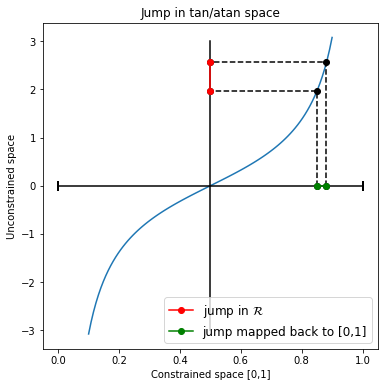

In [86]:
# perform manually
p = 0.85
r = np.tan(np.pi * (p - 0.5))
jump = 0.6
r_star = r + jump
p_star = np.arctan(r_star) / np.pi + 0.5

# plot
plt.figure(figsize=(6,6))
ps = np.linspace(0.1, 0.9, 100)
ax = plt.axes()
plt.plot(ps, np.tan(np.pi * (ps - 0.5)))
plt.plot([0, 1.0], [0, 0], 'k-|', markersize=10, markeredgewidth=2)
plt.plot([0.5, 0.5], [-3, 3], 'k-')
plt.plot([p, p, 0.5], [0,r,r], 'ok--')
plt.plot([p_star, p_star, 0.5], [0, r_star, r_star], 'ok--');
plt.plot([0.5, 0.5], [r, r_star], 'ro-', label='jump in ${\cal R}$')
plt.plot([p, p_star], [0.0,0.0], 'go-', label='jump mapped back to [0,1]')
plt.legend(fontsize=12)
plt.xlabel('Constrained space [0,1]')
plt.ylabel('Unconstrained space')
plt.title('Jump in tan/atan space');

In [110]:
# construction using the log odds pair
def propose_new_p_logodds(p):
    # m: (0,1) -> R
    r = np.log(p / (1-p))
    # random walk proposal in unconstrained space
    r_star = propose_unconstrained(r)
    # m^{-1}: R -> (0,1)
    p_star = np.exp(r) / (np.exp(r) + 1)
    return p_star

### Proposal for the positive case

This type of proposal works for random variables such as standard deviations or variances.  It is also useful when we want to enforce positivity of some variable. For example in notebook 3f.1. the shift variable $\tau$ should be positive.

In [87]:
# proposal for positive values
def proposal_sigma_log(sigma):
    # m: (0,+inf) -> R
    r = np.log(sigma)
    # random walk proposal in unconstrained space
    r_star = propose_unconstrained(r)
    # m^{-1}: R -> (0,1)
    p_star = np.exp(r_star)
    return p_star

## Modulo and reflection proposal for fininte intervals

For the constraint to $[0,1]$ (or any finite interval) there are at least two other interesting proposals suitable for different situations.  These are not bijective mappings and the above analysis does not apply.

The module proposal, which introduces a circular topology (like time of day, 11pm=23 hours is two hours away from 1am) and is suitable for time of day, day of year and such random variables.  It makes sense to propose 1am starting from a time like 11:30 pm since those two are close - this is a small jump.

The reflection proposal may be more suitable for random variables like a probability of heads, $p_H = 0.01$ is not at all close to $p_H=0.9$, so a jump that would wrap around would be huge.  It's more appropriate to select small jumps and use a reflective proposal or use a bijection-based approach.

In [12]:
def modulo_proposal(origin, jump_delta):
    return (origin+jump_delta) % 1

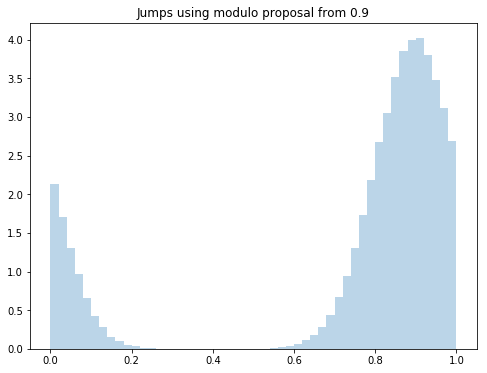

In [24]:
origin = 0.9
targets = [modulo_proposal(origin, jd) for jd in nr.randn(100000) * 0.1]
plt.figure(figsize=(8,6))
plt.hist(targets, bins=50, alpha=0.3, density=True)
plt.title('Jumps using modulo proposal from 0.9');

In [5]:
def reflecting_proposal1(origin, jump_delta):
    xp = origin + jump_delta
    while xp < 0. or xp > 1.:
        if xp < 0:
            xp = -xp
        if xp > 1.:
            xp = 2 - xp
    return xp 

In [6]:
def reflecting_proposal2(origin, jump_delta):
    xp = (origin + jump_delta) % 2.
    return xp if xp < 1. else 2. - xp

Below we show the behavior of the reflection proposal function and to illustrate how it's different from the original normally distributed jump, we visualise both at the same time.  We see that the reflected proposal distribution is higher than the original.  This is since it's restricted to $[0,1]$ 

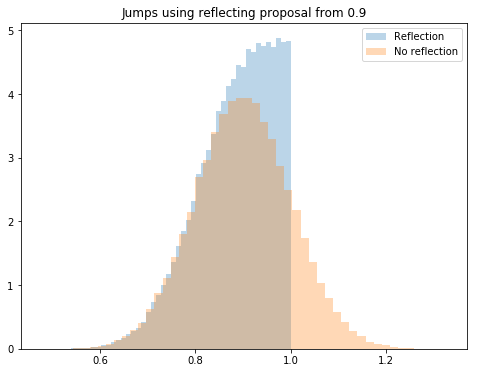

In [23]:
origin = 0.9
jumps = nr.randn(100000) * 0.1
targets = [reflecting_proposal2(origin, jd) for jd in jumps]
raw_jumps = origin + jumps
plt.figure(figsize=(8,6))
plt.hist(targets, bins=50, alpha=0.3, density=True)
plt.hist(raw_jumps, bins=50, alpha=0.3, density=True)
plt.title('Jumps using reflecting proposal from 0.9')
plt.legend(['Reflection', 'No reflection']);

### Visualization of jumps
Below we compare jumps from origin to target for both modular and reflection proposal assuming that the jump origin is uniformly distributed on $[0,1]$.  The way to read the figures is to pick the origin on the x-axis and the target on the y-axis.  If you swap the origin and target, you should read off the same intensity from the plot.  In other words the figures needs to be symmetric with respect to the main diagonal.

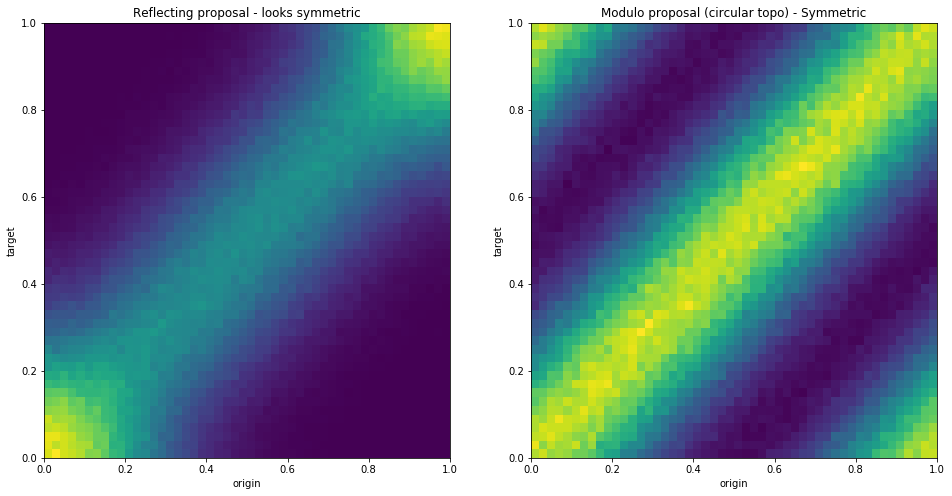

In [106]:
plt.figure(figsize=(16,8))

stdev = 0.2

plt.subplot(1,2,1)
orig = np.random.rand(10000)
jumps = np.random.randn(1000000) * stdev`
tgt = [reflecting_proposal(o,j) for o,j in zip(orig,jumps)]
plt.hist2d(orig,tgt, bins=[50,50]);
plt.xlabel('origin')
plt.ylabel('target')
plt.title('Reflecting proposal - looks symmetric')

plt.subplot(1,2,2)
tgt = [modulo_proposal(o,j) for o,j in zip(orig,jumps)]
plt.hist2d(orig,tgt, bins=[50,50]);
plt.xlabel('origin')
plt.ylabel('target')
plt.title('Modulo proposal (circular topo) - Symmetric');

### Absolute value proposal for positive random variables

For a positive random variable $\sigma \geq 0$, we can also perform a one-sided reflection proposal using the absolute value, so that:

In [90]:
def proposal_sigma_abs(sigma, jump):
    return np.abs(sigma + jump)

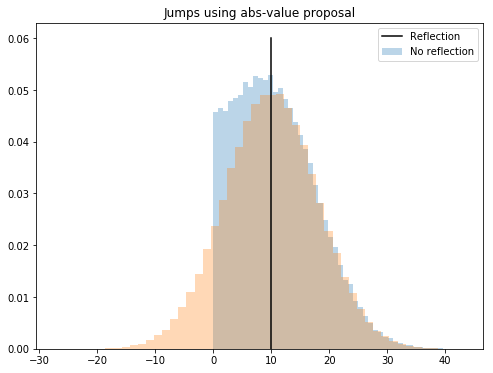

In [94]:
origin = 10
jumps = nr.randn(100000) * 8
targets = [proposal_sigma_abs(origin, jd) for jd in jumps]
raw_jumps = origin + jumps
plt.figure(figsize=(8,6))
plt.hist(targets, bins=50, alpha=0.3, density=True)
plt.hist(raw_jumps, bins=50, alpha=0.3, density=True)
plt.plot([origin, origin], [0, 0.06], 'k-')
plt.title('Jumps using abs-value proposal')
plt.legend(['Abs value', 'No reflection']);